# Import Libraries

In [1]:
import json
import graphviz 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# variable for consistent random selections
RANDOM_STATE = 21

%matplotlib inline

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load data

In [34]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [35]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

# Data Exploration

### Look for missing values

In [38]:
# Missing values
(df.count() - df.count().max()).abs()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Check values to make sure they make sense

In [39]:
# All potential categorical values
categories = {}
for col in df:
    if df[col].dtype == object and col != 'customerID':
        categories[col] = list(df[col].unique())

print(json.dumps(categories, indent=2))

{
  "gender": [
    "Female",
    "Male"
  ],
  "Partner": [
    "Yes",
    "No"
  ],
  "Dependents": [
    "No",
    "Yes"
  ],
  "PhoneService": [
    "No",
    "Yes"
  ],
  "MultipleLines": [
    "No phone service",
    "No",
    "Yes"
  ],
  "InternetService": [
    "DSL",
    "Fiber optic",
    "No"
  ],
  "OnlineSecurity": [
    "No",
    "Yes",
    "No internet service"
  ],
  "OnlineBackup": [
    "Yes",
    "No",
    "No internet service"
  ],
  "DeviceProtection": [
    "No",
    "Yes",
    "No internet service"
  ],
  "TechSupport": [
    "No",
    "Yes",
    "No internet service"
  ],
  "StreamingTV": [
    "No",
    "Yes",
    "No internet service"
  ],
  "StreamingMovies": [
    "No",
    "Yes",
    "No internet service"
  ],
  "Contract": [
    "Month-to-month",
    "One year",
    "Two year"
  ],
  "PaperlessBilling": [
    "Yes",
    "No"
  ],
  "PaymentMethod": [
    "Electronic check",
    "Mailed check",
    "Bank transfer (automatic)",
    "Credit card (automatic)"

In [40]:
# Numerical values
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### Correlation analysis

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
MonthlyCharges,0.220173,0.247900,1.000000,0.651174
TotalCharges,0.103006,0.826178,0.651174,1.000000


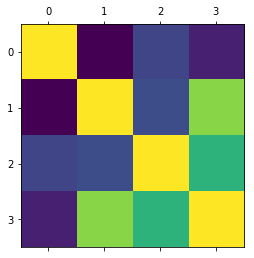

In [41]:
plt.matshow(df.corr())
df.corr()

# Check for target balance

In [121]:
print(1869.0 / X.shape[0])
df[['Churn', 'Contract']].groupby('Churn').count()

0.2653698707936959


,Contract
Churn,
No,5174
Yes,1869


# Create datasets

In [116]:
# Create one-hot encodings of categorical variables
categorical_columns = [x for x in categories.keys() if x != 'Churn']
X = pd.get_dummies(df, columns=categorical_columns)
X_df = X

# Get y labels as 1 or 0
y = np.where(X['Churn'] == 'Yes', 1, 0)
X.drop(columns=['customerID', "Churn"], inplace=True)
cols = X.columns

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Helper functions

In [123]:
def plot_curves(title, xlabel, ylabel, train_set, test_set, metric_label, ylim_min=0.75):
    plt.plot(train_set, linewidth=3, label='Training ' + metric_label)
    plt.plot(test_set, linewidth=3, label='Test ' + metric_label)
    plt.legend()
    plt.title(title)
    plt.ylim(ylim_min, 1.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figure(figsize=(12,12))
    plt.show()
    
def learning_curve(clf_name, clf, step=5):
    train_auc, test_auc = [], []
    x_step = []
    for i in range(step, 101, step):
        pct = 1.0 * i / 100
        upper = int(X_train.shape[0] * pct) - 1
        X_train_sub = X_train[:upper]
        y_train_sub = y_train[:upper]
        x_step.append(upper)
        
        clf = clf.fit(X_train_sub, y_train_sub)
        train_auc.append(roc_auc_score(y_train_sub, clf.predict_proba(X_train_sub)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        
    plt.plot(np.array(x_step), np.array(train_auc), label='Training AUC')
    plt.plot(np.array(x_step), np.array(test_auc), label='Test AUC')
    plt.legend()
    plt.title('Telco ' + clf_name + ' Learning Curves')
    plt.ylim(0.50, 1.0)
    plt.xlabel('# of Samples')
    plt.ylabel('ROC AUC')
    plt.figure(figsize=(12,12))
    plt.show()

# Decision Tree

In [74]:
dt_clf = tree.DecisionTreeClassifier(max_depth=4, criterion='entropy')
dt_clf = dt_clf.fit(X_train, y_train)

### Plot tree

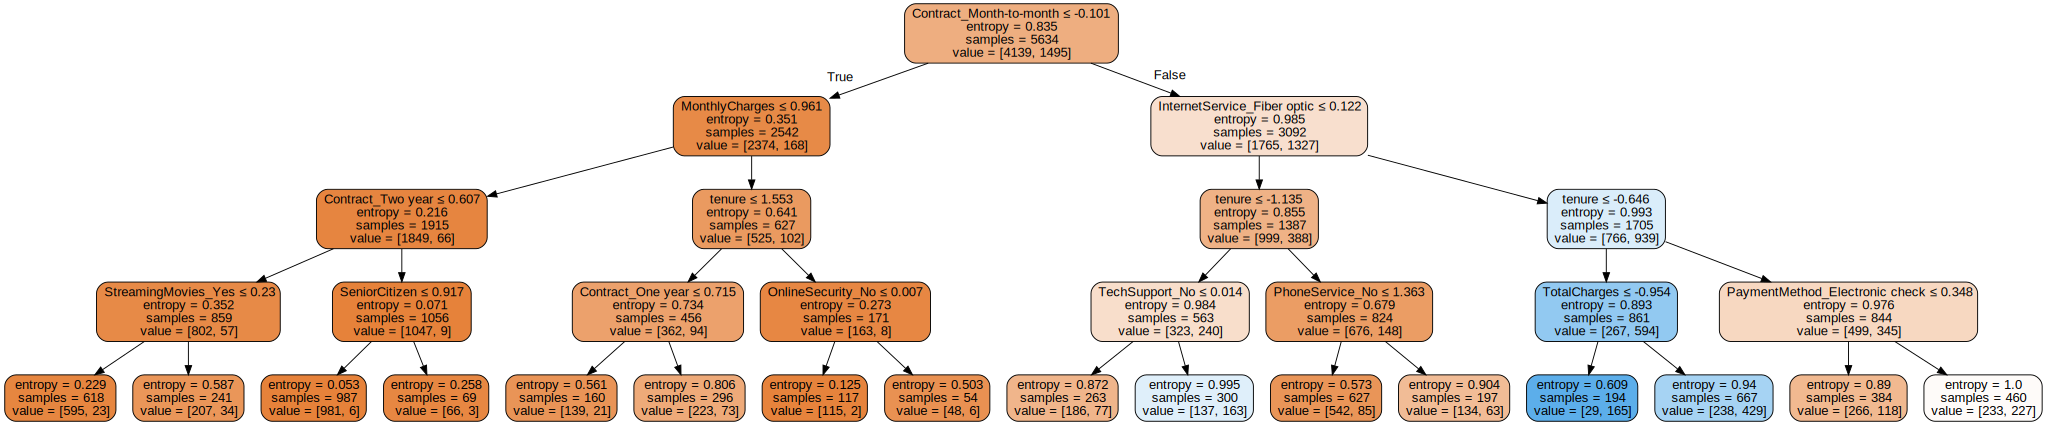

In [75]:
dot_data = tree.export_graphviz(dt_clf, out_file=None)
dot_data = tree.export_graphviz(dt_clf, out_file=None, 
                         feature_names=X_df.columns,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

### Model complexity curves

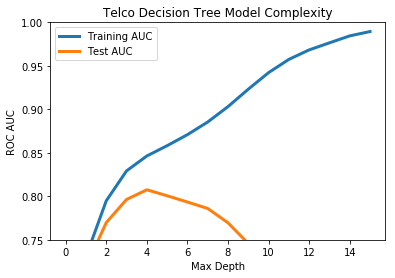

<Figure size 864x864 with 0 Axes>

In [119]:
max_depth = 16
train_auc, test_auc = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1, max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy')
    clf = clf.fit(X_train, y_train)
    train_auc[i] = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    test_auc[i] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

plot_curves('Telco Decision Tree Model Complexity', 'Max Depth', 'ROC AUC', train_auc, test_auc, 'AUC')

### Learning curves

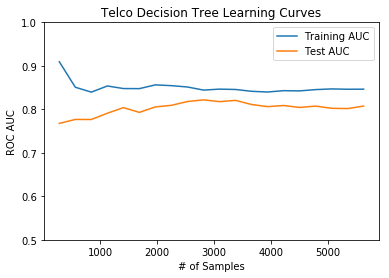

<Figure size 864x864 with 0 Axes>

In [120]:
learning_curve('Telco Decision Tree', dt_clf)

# Neural Network (Multi-layer perceptron)

In [130]:
mlp_clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu',
                        learning_rate='constant', random_state=RANDOM_STATE,
                        hidden_layer_sizes=(30, 30), max_iter=3)
mlp_clf.fit(X_train, y_train)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=3, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=21, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Model complexity curves

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimize

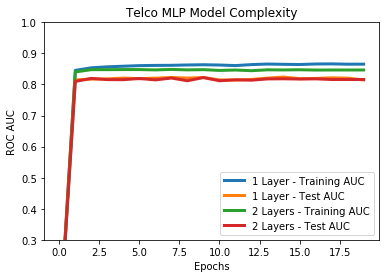

<Figure size 864x864 with 0 Axes>

In [122]:
epochs = 20
train_auc1, test_auc1 = np.zeros(epochs), np.zeros(epochs)
train_auc2, test_auc2 = np.zeros(epochs), np.zeros(epochs)
for i in range(1, epochs):
    # Single layer
    clf1 = MLPClassifier(solver='adam', alpha=0.1, activation='relu', batch_size=20,
                        learning_rate='constant', random_state=RANDOM_STATE,
                        hidden_layer_sizes=(30), max_iter=i)
    clf1 = clf1.fit(X_train, y_train)
    train_auc1[i] = roc_auc_score(y_train, clf1.predict_proba(X_train)[:,1])
    test_auc1[i] = roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1])

    # Two layers
    clf2 = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                        learning_rate='constant', random_state=1,
                        hidden_layer_sizes=(30, 30), max_iter=i)
    clf2 = clf2.fit(X_train, y_train)
    train_auc2[i] = roc_auc_score(y_train, clf2.predict_proba(X_train)[:,1])
    test_auc2[i] = roc_auc_score(y_test, clf2.predict_proba(X_test)[:,1])

# Create plot
plt.plot(train_auc1, linewidth=3, label='1 Layer - Training AUC')
plt.plot(test_auc1, linewidth=3, label='1 Layer - Test AUC')
plt.plot(train_auc2, linewidth=3, label='2 Layers - Training AUC')
plt.plot(test_auc2, linewidth=3, label='2 Layers - Test AUC')
plt.legend()
plt.title('Telco MLP Model Complexity')
plt.ylim(0.3, 1.0)
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

# Learning curves

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


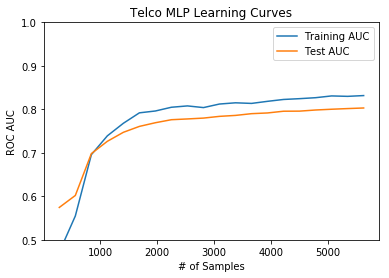

<Figure size 864x864 with 0 Axes>

In [131]:
learning_curve('MLP', mlp_clf)

# Boosting

In [88]:
boost_clf = GradientBoostingClassifier(max_depth=5, n_estimators=20)
boost_clf = boost_clf.fit(X_train, y_train)

### Model complexity curves

Depth 4 done.
Depth 5 done.
Depth 6 done.


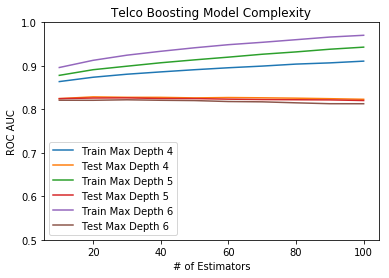

<Figure size 864x864 with 0 Axes>

In [132]:
n_estimators, n_step = (101, 10)
min_depth, max_depth = (4, 7)
for i in range(min_depth, max_depth):
    train_auc, test_auc = [], []
    x_step = []
    for j in range(n_step, n_estimators, n_step):
        clf = GradientBoostingClassifier(max_depth=i, n_estimators=j)
        clf = clf.fit(X_train, y_train)
        x_step.append(j)
        
        train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    
    plt.plot(np.array(x_step), np.array(train_auc), label='Train Max Depth %d' % i)
    plt.plot(np.array(x_step), np.array(test_auc), label='Test Max Depth %d' % i)
    print('Depth %s done.' % i)

plt.legend()
plt.title('Telco Boosting Model Complexity')
plt.ylim(0.5, 1.0)
plt.xlabel('# of Estimators')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

### Learning curves

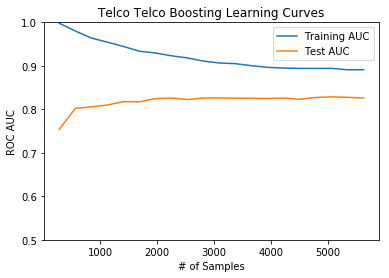

<Figure size 864x864 with 0 Axes>

In [133]:
learning_curve('Telco Boosting', GradientBoostingClassifier(max_depth=5, n_estimators=20))

# Support Vector Machines

In [94]:
svm_clf = SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)
svm_clf = svm_clf.fit(X_train, y_train)

### Model selection

In [93]:
kernels = (('linear', 0), ('poly', 2), ('poly', 3), ('rbf', 0))
for k in kernels:
    clf = SVC(kernel=k[0], degree=k[1], random_state=RANDOM_STATE, probability=True)
    clf = clf.fit(X_train, y_train)

    train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    cross_val_auc = np.mean(cross_val_score(clf, X, y, cv=5, scoring='roc_auc'))
    
    print(k, {'train_auc': train_auc, 'test_auc': test_auc, 'cross_val_auc': cross_val_auc})

('linear', 0) {'train_auc': 0.8442364457186353, 'test_auc': 0.8194373401534527, 'cross_val_auc': 0.833232383885943}
('poly', 2) {'train_auc': 0.8440596463527859, 'test_auc': 0.78966777751944, 'cross_val_auc': 0.8123018893371199}
('poly', 3) {'train_auc': 0.8860490109174416, 'test_auc': 0.798437055981813, 'cross_val_auc': 0.8116770925980319}
('rbf', 0) {'train_auc': 0.8773384099854472, 'test_auc': 0.7817368053940943, 'cross_val_auc': 0.798771167993567}


### Learning curves

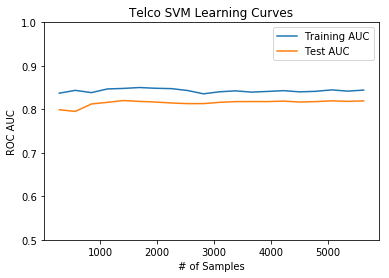

<Figure size 864x864 with 0 Axes>

In [135]:
learning_curve('SVM', SVC(kernel='linear', random_state=RANDOM_STATE, probability=True))

# K-Nearest Neighbors

In [100]:
knn_clf = KNeighborsClassifier(n_neighbors=60)
knn_clf = knn_clf.fit(X_train, y_train)

### Model complexity

1 neighbors
6 neighbors
11 neighbors
16 neighbors
21 neighbors
26 neighbors
31 neighbors
36 neighbors
41 neighbors
46 neighbors
51 neighbors
56 neighbors
61 neighbors
66 neighbors
71 neighbors
76 neighbors
81 neighbors
86 neighbors
91 neighbors
96 neighbors


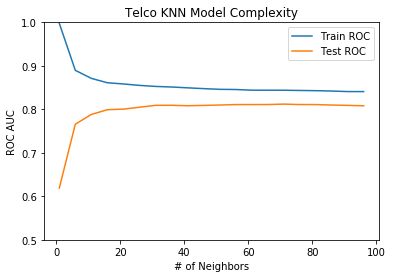

<Figure size 864x864 with 0 Axes>

In [139]:
max_neighbors, step = (101, 5)
train_auc, test_auc = [], []
x_step = []
for i in range(1, max_neighbors, step):
    print('%d neighbors' % i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf = clf.fit(X_train, y_train)
    x_step.append(i)

    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

plt.plot(np.array(x_step), np.array(train_auc), label='Train ROC')
plt.plot(np.array(x_step), np.array(test_auc), label='Test ROC')
plt.legend()
plt.title('Telco KNN Model Complexity')
plt.ylim(0.5, 1.0)
plt.xlabel('# of Neighbors')
plt.ylabel('ROC AUC')
plt.figure(figsize=(12,12))
plt.show()

### Learning curves

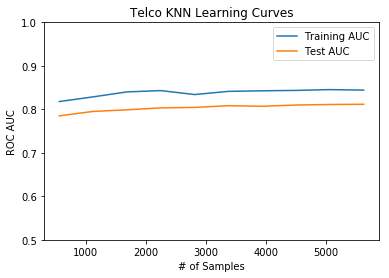

<Figure size 864x864 with 0 Axes>

In [138]:
learning_curve('KNN', knn_clf, step=10)

# Summary of all classifiers

In [144]:
from IPython.display import HTML, display
import tabulate

classifiers = [('Decision Tree', dt_clf), ('Multi-Layer Perceptron', mlp_clf), ('Boosting', boost_clf),
               ('Support Vector Machine', svm_clf), ('K-Nearest Neighbor', knn_clf)]
table = [['Classifier', 'Train Accuracy', 'Test Accuracy', 'Train F1 Score', 'Test F1 Score',
          'Train ROC AUC', 'Test ROC AUC', 'Cross-Val ROC AUC']]
for clf_name, clf in classifiers:
    y_train_prob = clf.predict_proba(X_train)[:,1]
    y_train_hat = np.where(y_train_prob > 0.5, 1, 0)

    train_accuracy = accuracy_score(y_train, y_train_hat)
    train_f1 = f1_score(y_train, y_train_hat, average='macro')
    train_roc = roc_auc_score(y_train, y_train_hat)

    y_test_prob = clf.predict_proba(X_test)[:,1]
    y_test_hat = np.where(y_test_prob > 0.5, 1, 0)

    test_accuracy = accuracy_score(y_test, y_test_hat)
    test_f1 = f1_score(y_test, y_test_hat, average='macro')
    test_roc = roc_auc_score(y_test, y_test_hat)
    
    cross_val_auc = np.mean(cross_val_score(clf, X, y, cv=5, scoring='roc_auc'))
    
    print([clf_name, train_accuracy, test_accuracy, train_f1, test_f1, train_roc, test_roc, cross_val_auc])
    table.append([clf_name, train_accuracy, test_accuracy, train_f1, test_f1, train_roc, test_roc, cross_val_auc])

# Display as table    
display(HTML(tabulate.tabulate(table, tablefmt='html')))

['Decision Tree', 0.7973020944266951, 0.7906316536550745, 0.718712226985042, 0.7014789773775999, 0.7043731985736461, 0.6850189878322871, 0.8292421165903479]


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimize

['Multi-Layer Perceptron', 0.7925097621583245, 0.7806955287437899, 0.7048016184006797, 0.6859187493913239, 0.6882927791034138, 0.6705714433335916, 0.8221751519629213]
['Boosting', 0.826588569400071, 0.7955997161107168, 0.7530137194857243, 0.7022278317532067, 0.7315695145532221, 0.6832777906946705, 0.8447131230777373]
['Support Vector Machine', 0.8077742279020235, 0.7877927608232789, 0.7335911659959533, 0.706964896941672, 0.7183371971159401, 0.6941861065901986, 0.833232383885943]
['K-Nearest Neighbor', 0.8006744763933262, 0.7842441447835344, 0.7400381253848131, 0.7174669009588036, 0.7361515917195192, 0.7131158128600584, 0.8288044646498806]


Classifier,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC,Cross-Val ROC AUC
Decision Tree,0.7973020944266951,0.7906316536550745,0.718712226985042,0.7014789773775999,0.7043731985736461,0.6850189878322871,0.8292421165903479
Multi-Layer Perceptron,0.7925097621583245,0.7806955287437899,0.7048016184006797,0.6859187493913239,0.6882927791034138,0.6705714433335916,0.8221751519629213
Boosting,0.826588569400071,0.7955997161107168,0.7530137194857243,0.7022278317532067,0.7315695145532221,0.6832777906946705,0.8447131230777373
Support Vector Machine,0.8077742279020235,0.7877927608232789,0.7335911659959533,0.706964896941672,0.7183371971159401,0.6941861065901986,0.833232383885943
K-Nearest Neighbor,0.8006744763933262,0.7842441447835344,0.7400381253848131,0.7174669009588036,0.7361515917195192,0.7131158128600584,0.8288044646498806


# Feature importances

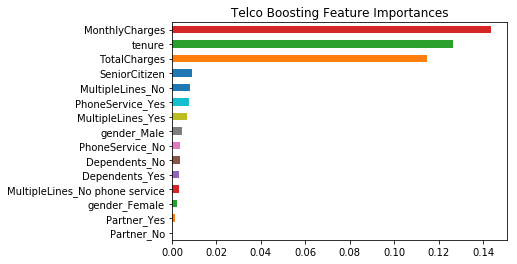

In [141]:
clf = boost_clf
feature_importances = pd.Series(clf.feature_importances_, index=cols)
feature_importances = feature_importances.head(15).sort_values()
feature_importances.plot('barh', title='Telco Boosting Feature Importances')

,MonthlyCharges,tenure,TotalCharges,Churn
MonthlyCharges,1.000000,0.247900,0.651174,0.193356
tenure,0.247900,1.000000,0.826178,-0.352229
TotalCharges,0.651174,0.826178,1.000000,-0.198324
Churn,0.193356,-0.352229,-0.198324,1.000000


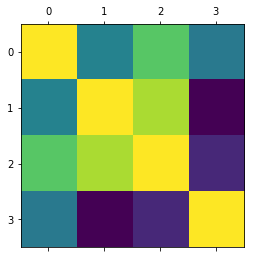

In [150]:
# Correlation Analysis
X_df = pd.get_dummies(df, columns=categorical_columns)
X_df['Churn'] = np.where(X_df['Churn'] == 'Yes', 1, 0)
X_df = X_df[['MonthlyCharges', 'tenure', 'TotalCharges', 'Churn']]

plt.matshow(X_df.corr())
X_df.corr()
